# MAP 568 Project

Maxime Vincent & Swann Chelly

In [1]:
import numpy as np

from constant import *
from scipy import *
from pylab import *     
from scipy.integrate import odeint # Module de résolution des équations différentielles
import plotly as po
from progressbar import ProgressBar
import matplotlib.pyplot as plt

## Incertitudes en sortie

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [24]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps,variables,constants):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : 
    
    temps : 
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    #temps = round(temps,1)
    #if temps == 50:
    #    temps = 50.1
    #elif temps > 100.:
    #    temps = 100.
    #i = time.index(temps)
    
    if type(variables)!= dict:
        variables = dict(zip(variables_keys,variables))
        constants = dict(zip(constants_keys, constants))
    else : 
        variables = variables
        constants = constants    
    
    tau = constants['tau_0']*np.exp(-variables['mu']*max(temps-(variables['N']-variables['t_0']),0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_moins
    DI_plus = variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_plus
    DR_moins = constants['gamma_IR']*I_moins
    DR_plus_I = constants['gamma_IR']*I_plus
    DH = constants['gamma_IH']*(I_moins + I_plus)-(constants['gamma_HR']+constants['gamma_HD']+constants['gamma_HU'])*H
    DU = constants['gamma_IU']*(I_moins + I_plus)+constants['gamma_HU']*H-(constants['gamma_UR'] + constants['gamma_UD'])*U
    DR_plus_H = constants['gamma_HR']*H+constants['gamma_UR']*U
    DD =constants['gamma_UD']*U+constants['gamma_HD']*H  
    DD_R = (variables['lambda_1']+constants['gamma_IH']+constants['gamma_IU'])*I_moins-D_R
    
    
    return(DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R)


Text(0, 0.5, 'Nombre de personne en réanimation')

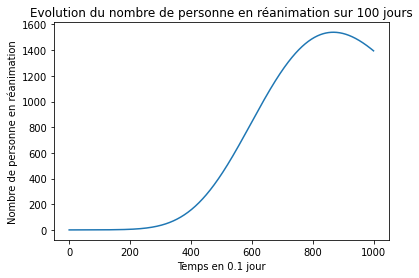

In [3]:
# Analyse des résultats

variables = init_variables()
constants = compute_constants(variables)

syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
plt.plot(simulation[:,6])
plt.title(f"Evolution du nombre de personne en réanimation sur {global_constants['T_MAX']} jours")
plt.xlabel(f"Temps en {global_constants['deltaT']} jour")
plt.ylabel("Nombre de personne en réanimation")




2) **Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d'entrée de la table 1), donner :**
- la loi du nombre maximal de patients présents en soins intensifs (histogramme, moyenne, quantiles à 10% et 90%),
- la loi de la date du pic de l'épidémie.

In [4]:
## Implémentation de la méthode de Monte Carlo classique pour la résolution du système différentiel. 

M = 1000

def Monte_Carlo(M):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
        Nombre de cas au pic de l'épidémie pour chaque simulation.
    
    """
    
    print(f"Echantillonnage de Monte Carlo sur 10000 simulation")
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        variables = init_variables()
        constants = compute_constants(variables)
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))      
        peak_value.append(np.max(simulation[:,6]))
        peak_day.append(int(np.argmax(list(simulation[:,6]))*global_constants['deltaT']))
        pos.append(np.max(simulation[:,1]))
        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M)


Echantillonnage de Monte Carlo sur 10000 simulation


100% |########################################################################|


La valeur moyenne du pic est de 19663.3 et appartient à l'intervalle de confiance à 95% suivant : [16326.53,23000.07] 
 Le quantile à 10% du pic de réanimation est : 0.5510131411866986
 Le quantile à 90% du pic de réanimation est : 56506.78179231247


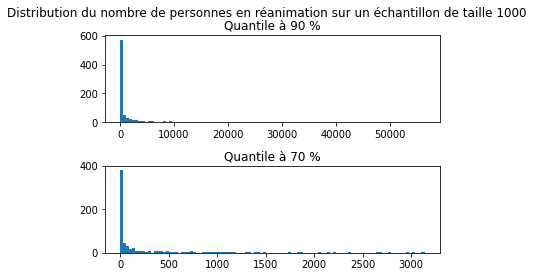

In [5]:
mean_value = np.mean(peak_value)
var_value  = np.var(peak_value)
q_10 = np.quantile(peak_value, 0.1, axis = None)
q_70 = np.quantile(peak_value, 0.7, axis = None)
q_90 = np.quantile(peak_value, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_value,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_value-1.96*np.sqrt(var_value/M),2))},{round(mean_value+1.96*np.sqrt(var_value/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 


fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du nombre de personnes en réanimation sur un échantillon de taille {M}")
axs[0].hist([value for value in peak_value if value < q_90], bins = 100)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([value for value in peak_value if value < q_70], bins = 100)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

En supposant que la distribution du nombre de cas en réanimation au pic de l'épidémie suis une loie exponentielle, nous pouvons donner son paramètre $\lambda = \frac{1}{\mathbb{\hat{E}}(X)}$ où $X$ correspond à la variable aléatoire liée au nombre de cas en réanimation au pic de l'épidémie. Nous la notrons ici `lbd`.


5.085616156126624e-05


(array([18246.74821761, 17663.62976592, 15695.60499145, 14262.10546437,
        13338.83458252, 12609.9365179 , 12075.41127051, 10641.91174343,
         9135.52240988,  8090.76851726,  9524.26804435,  8333.7345388 ,
         7677.72628065,  7021.71802249,  7313.27724834,  5661.10830187,
         5393.84567818,  5102.28645233,  4713.54081787,  3911.75294679,
         3814.56653817,  3425.82090371,  3037.07526924,  2745.5160434 ,
         2016.61797878,  2842.70245201,  2405.36361324,  1797.94855939,
         1797.94855939,  1992.32137662,  1822.24516155,  1457.79612924,
         1336.31311847,  1554.98253785,  1506.38933354,  1214.8301077 ,
          728.89806462,   801.78787108,   826.08447323,   850.38107539,
          631.711656  ,   680.30486031,   461.63544092,   461.63544092,
          388.74563446,   583.11845169,   291.55922585,   388.74563446,
          242.96602154,   413.04223662,   315.855828  ,   145.77961292,
          218.66941939,   194.37281723,   121.48301077,   388.74

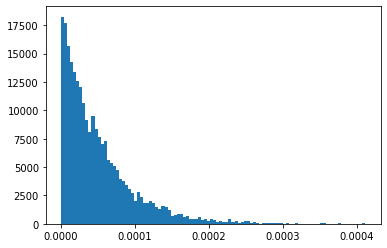

In [6]:
lbd = 1/mean_value
print(lbd)
Y = np.random.exponential(lbd,10000)
plt.hist(Y,bins = 100,density = True)

La valeur moyenne du pic est de 57.21 et appartient à l'intervalle de confiance à 95% suivant : [55.82,58.61] 
 Le quantile à 10% du pic de réanimation est : 26.0
 Le quantile à 90% du pic de réanimation est : 89.0


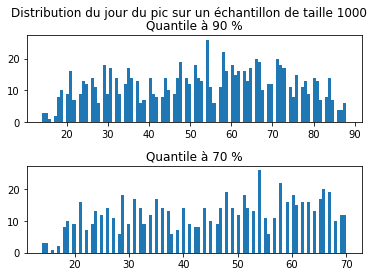

In [7]:
# Loi de la date de l'épidémie. 

mean_day = np.mean(peak_day)
var_day  = np.var(peak_day)
q_10_day = np.quantile(peak_day, 0.1, axis = None)
q_70_day = np.quantile(peak_day, 0.7, axis = None)
q_90_day = np.quantile(peak_day, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_day,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_day-1.96*np.sqrt(var_day/M),2))},{round(mean_day+1.96*np.sqrt(var_day/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10_day}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90_day}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du jour du pic sur un échantillon de taille {M}")
axs[0].hist([day for day in peak_day if day < q_90_day], bins = 100)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([day for day in peak_day if day < q_70_day], bins = 100)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

# Calibration

In [8]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import ticker

In [9]:

contamination = pd.read_csv('data_per_day.csv', sep = ';')
contamination.columns = [jour,'detecte']
contamination[jour] = pd.to_datetime(contamination[jour],infer_datetime_format = True)
contamination = contamination[contamination[jour]<= '2020-05-11']
contamination['detecte'] = contamination['detecte'].diff(periods = 1)

 
hosp          = pd.read_csv('donnees_hospitalieres.csv', ';')
hosp[jour]    = pd.to_datetime(hosp[jour])
hosp          = hosp.groupby(jour).agg('sum').reset_index(False)[[jour,'hosp','rea','rad','dc']]
big_table     = hosp.merge(contamination, left_on= jour, right_on = jour)
big_table     = big_table[big_table[jour]<= '2020-05-11']
big_table.head()   

,jour,hosp,rea,rad,dc,detecte
0,2020-03-18,5905,1535,1627,435,1404.0
1,2020-03-19,7961,1975,2322,642,1861.0
2,2020-03-20,10272,2564,3128,890,1617.0
3,2020-03-21,11599,2872,3580,1041,1847.0
4,2020-03-22,13675,3311,4188,1251,1559.0


Text(0.5, 1.0, 'Spread of the epidemic')

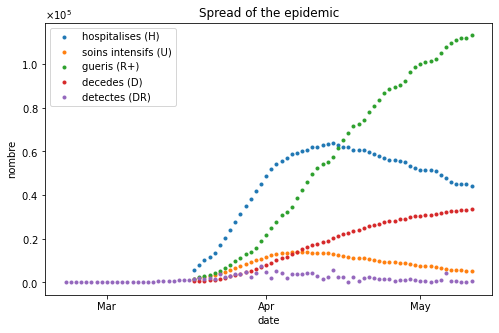

In [10]:
columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

# Calibration déterministe

In [11]:
from scipy.optimize import minimize


In [12]:
# Table pre-processing
contamination = contamination[('2020-02-25' <= contamination[jour])& (contamination[jour]<= '2020-03-31')]
big_table     = big_table[big_table[jour]<= '2020-03-31']


In [35]:


def Epsilon(variables,constants,contamination= contamination,big_table=big_table,global_constants=global_constants):
    """
    parameters will be a dictionnary similar to the one resulting from init_constant    
    """
    syst_CI=array([global_constants['S_0'],variables[-1],0,0,0,0,0,0,0,0])
    simulation=odeint(equa_diff,syst_CI,constants[-2],args = (variables,constants))[::10]
    
    DR = ((simulation[30:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[30:,-1]))**2
    
    H  = ((simulation[52:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[52:,5]))**2
    U  = ((simulation[52:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[52:,6]))**2
    D  = ((simulation[52:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[52:,8]))**2
    R  = ((simulation[52:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[52:,7]))**2
    return np.sum(DR) + np.sum(H+U+D+R)



In [36]:

variables = init_variables(T_MAX = 66)
constants = compute_constants(variables, global_constants = global_constants)
variables = list(variables.values())
constants = list(constants.values())

res = minimize(Epsilon,x0 = variables,bounds = bound, args = (constants))
optimal_variables = dict(zip(variables_keys,res.x))

In [46]:
constants   = compute_constants(optimal_variables)
syst_CI    = array([global_constants['S_0'],optimal_variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation = odeint(equa_diff,syst_CI,constants['t'], args = (optimal_variables,constants))[::10]

Text(0.5, 1.0, 'Spread of the epidemic')

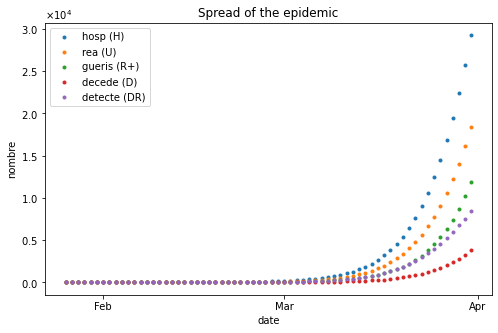

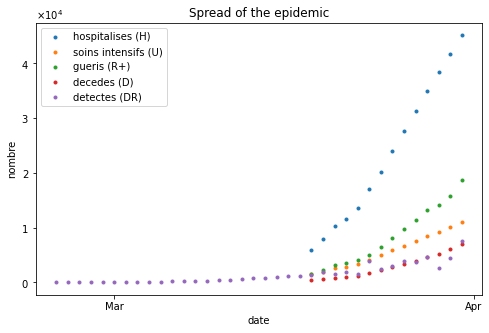

In [54]:
fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
columns  = [5,6,7,8,9]
titles   = {'5':'hosp (H)','6': 'rea (U)','8':'decede (D)', '9':'detecte (DR)','7': 'gueris (R+)'}
time     = pd.date_range(start =  '2020-01-26', end = '2020-03-31', freq = 'D')

for i,col in enumerate(columns) : 
    axs.scatter(time,simulation[:,col],marker = '.', label = titles[f"{col}"])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')



columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')